In [41]:
from shapely.geometry import MultiPolygon, Polygon, LineString
import gdal
import geopandas as gpd
ds=gdal.Open('/data4/Ukraine_img/M_and_L_inference/20220528T082611_20220528T083641_T37TCN2_MRSV4.tif')
img=ds.ReadAsArray()

trf=ds.GetGeoTransform()
def get_patch_geometry(trf,coord):
    lightup_all=[trf[0]-trf[1]/2,trf[3]-trf[5]/2]
    patch_size=trf[1]
    lightup_patch=[lightup_all[0]+patch_size*coord[0],lightup_all[1]-patch_size*coord[1]]
    bound=[(lightup_patch[0],lightup_patch[1]),
        (lightup_patch[0]+patch_size,lightup_patch[1]),
        (lightup_patch[0]+patch_size,lightup_patch[1]-patch_size),
        (lightup_patch[0],lightup_patch[1]-patch_size)]
    square=Polygon(bound)
    return square
from tqdm import tqdm
geometry=[]
value=[]
coords=[]
for x in tqdm(range(img.shape[1])):
    for y in range(img.shape[0]):
        if img[y,x]>1:
            geometry.append(get_patch_geometry(trf,[x,y]))
            value.append(img[y,x])
            coords.append([y,x])
        elif img[y,x]==-1:
            geometry.append(get_patch_geometry(trf,[x,y]))
            value.append(0)
            coords.append([y,x])
x=[i[1] for i in coords]
y=[i[0] for i in coords]            
import datetime
date_index={}
for i in range(25):
    date_index[i*5+4]=(datetime.datetime.strptime('2022-2-27', "%Y-%m-%d")+datetime.timedelta(days=5*i)).strftime("%Y-%m-%d")
date_index[0]=None
date_index[1]=None
date_index[2]=None
date=[date_index[i] for i in value]
id=list(range(len(value)))
patch_ploygon=gpd.GeoDataFrame({'patch_id':id,'geometry':geometry,'date_id':value,'x':x,'y':y,'date':date})
patch_ploygon=patch_ploygon.set_crs(4326)

100%|██████████| 607/607 [00:00<00:00, 1001.86it/s]


In [13]:
import geopandas as gpd
f=gpd.read_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/buildings.shp')
del f['name']
building_type=list(f['type'])
building_type=[i if i is not None else 'Nonee' for i in building_type]
f['type']=building_type
points=[i.centroid for i in f['geometry']]
point_gpd=f.copy()
point_gpd['geometry']=points
point_gpd

,osm_id,type,geometry
0,50449693,school,POINT (37.51316 47.18676)
1,50449694,Nonee,POINT (37.51301 47.18652)
2,93130390,Nonee,POINT (37.55535 47.11385)
3,93130424,Nonee,POINT (37.56023 47.14006)
4,93953126,Nonee,POINT (37.55990 47.10670)
...,...,...,...
110710,1116104061,Nonee,POINT (37.31749 47.04477)
110711,1116104062,Nonee,POINT (37.31732 47.04444)
110712,1116104063,Nonee,POINT (37.31719 47.04577)
110713,1116104064,Nonee,POINT (37.31648 47.04539)


In [58]:
join=gpd.sjoin(f,patch_ploygon)
import pandas as pd
pd.value_counts(list(join['type']))

house            1311
Nonee             149
detached           70
industrial         66
apartments         35
garages            11
kindergarten        2
school              2
roof                2
service             2
sports_centre       1
grandstand          1
dtype: int64

In [59]:
patch_ploygon.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_patch.shp')

d_house_and_apartments=join[(join['type']=='house') | (join['type']=='apartments')]
d_house_and_apartments.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_house-and-apartments.shp')
d_industrial=join[join['type']=='industrial']
d_industrial.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_industrial.shp')
d_school=join[join['type']=='school']
d_school.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_school.shp')
d_garages=join[join['type']=='garages']
d_garages.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_garages.shp')
d_kindergarten=join[join['type']=='kindergarten']
d_kindergarten.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_kindergarten.shp')
d_sports_centre=join[join['type']=='sports_centre']
d_sports_centre.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_sportscentre.shp')
d_other=join[(join['type']=='Nonee') | (join['type']=='detached') | (join['type']=='service') | (join['type']=='roof') | (join['type']=='grandstand')]
d_other.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/OSM_MandL/d_other.shp')

/home/hk/miniconda3/envs/pythonhzy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  after removing the cwd from sys.path.
/home/hk/miniconda3/envs/pythonhzy/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
/home/hk/miniconda3/envs/pythonhzy/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
/home/hk/miniconda3/envs/pythonhzy/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  # Remove the CWD from sys.path while we load stuff.
/home/hk/miniconda3/envs/pythonhzy/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Column names longer than 10 characters will b

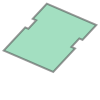

In [62]:
join.iloc[0]['geometry']

In [35]:
import rasterio
import numpy as np
from rasterio import crs
import os
import glob
import gdal
import osr
from pybob.image_tools import create_mask_from_shapefile
from pybob.GeoImg import GeoImg
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_Float32)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img
import geopandas as gpd
from glob import glob
import rasterio
def cut_img(shp_file,tif_file):
    #把shp投影转换为tif投影
    f=gpd.read_file(shp_file)
    f=f.to_crs(rasterio.open(tif_file).crs)
    f.to_file(shp_file.replace('.shp','_54009.shp'))
    ds=gdal.Open(tif_file)
    #建立mask
    mask=get_mask(shp_file.replace('.shp','_54009.shp'),ds.GetGeoTransform(),(50000,60000),p=ds.GetProjection())
    #mask cut img
    img=ds.ReadAsArray()
    img[mask==0]=np.nan
    p=ds.GetProjection()
    trf=ds.GetGeoTransform()
    #保存图像
    tif_save(img,tif_file.replace('.tif','_cut.tif'),trf,p=p)
    return img,mask
shp_file='/data4/urban2015_shp/urban_2015_dissolved/urban2015_extent_Kra_Dissolve.shp'
tif_file='/data4/urban2015_shp/CA_gdal/CA_1990_asian_gdal.tif'
img_cut,mask=cut_img(shp_file,tif_file)

In [9]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
device=torch.device("cpu")

In [11]:
w=torch.load('/home/hk/python_script/SupContrast-master/SupContrast-master/save/SupCon/allcities_size6v2_models/SupCon_allcities_size6v2_mynet6_lr_0.05_decay_0.0001_bsz_1024_temp_0.07_trial_0_cosine_warm/ckpt_epoch_1000.pth',map_location=device)

In [24]:
del w['model']['encoder.module.fn1.bias']

In [23]:
del w['model']['encoder.module.fn2.weight']

In [25]:
torch.save(w,'/home/hk/python_script/SupContrast-master/SupContrast-master/save/SupCon/allcities_size6v2_models/SupCon_allcities_size6v2_mynet6_lr_0.05_decay_0.0001_bsz_1024_temp_0.07_trial_0_cosine_warm/ckpt_epoch_1000_2.pth')